In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import gc

In [20]:
itemids = [50817,51301,51144,51288,50889,50861,53084,50878,53088,50885,53089,51842,52024,51237,51675,51240,51002,51003,52642,50809,50931,52569,50983,52623,50811,51222,51640,50902,52535,50882,50813,52442,53154,52022,53138,50862,53085,220045,220210,227242,227243,223762,53134,51300,51704,52159,52647,51006,50825]

##### Bases

In [21]:
BASES_HOSP = "../../Databases/MIMIC/"
BASES_ICU = "../../Databases/MIMIC/"
patient = "patients.csv"
admission = "admissions.csv"
diagnostics = "diagnoses_icd.csv"
icd_diagnostics = "d_icd_diagnoses.csv"
lab = "labevents.csv"
lab_items = "d_labitems.csv"
chart_items = "d_items.csv"
chart = "chartevents.csv"
icu = "icustays.csv"
id_dignoses = "d_icd_diagnoses.csv"

url_patient = BASES_HOSP + patient
url_admission = BASES_HOSP + admission
url_diagnostics = BASES_HOSP + diagnostics
url_icd_diagnostics = BASES_HOSP + icd_diagnostics
url_lab = BASES_HOSP + lab
url_lab_items = BASES_HOSP + lab_items
url_chart_items = BASES_HOSP + chart_items
url_chart = BASES_ICU + chart
url_icu = BASES_ICU + icu
url_id_dignoses = BASES_HOSP + id_dignoses

In [22]:
df_chartvents = pd.read_csv(url_chart)


In [23]:
df_selected_chartvents = df_chartvents[df_chartvents['itemid'].isin(itemids)][['subject_id', 'hadm_id','charttime','itemid', 'value']]
del df_chartvents
gc.collect()

513

In [24]:
df_labevents = pd.read_csv(url_lab)


In [25]:
df_selected_labevents = df_labevents[df_labevents['itemid'].isin(itemids)][['subject_id', 'hadm_id','charttime','itemid', 'value']]
del df_labevents
gc.collect()

0

In [26]:
df_admissions = pd.read_csv(url_admission)

In [27]:
df_diagnostics = pd.read_csv(url_diagnostics)

In [28]:
df_id = pd.read_csv(url_id_dignoses)

In [29]:
df_diagnostics = pd.read_csv(url_diagnostics)
df_id = pd.read_csv(url_id_dignoses)
df_diagnostics = pd.merge(df_diagnostics, df_id,how = "inner",on = ["icd_code","icd_version"])
del df_id
gc.collect()

0

In [30]:
df_diagnostics['sepsis'] = df_diagnostics['long_title'].str.contains("sepsis") | df_diagnostics['long_title'].str.contains("Sepsis")


In [31]:
df_diagnostics_sepsis = df_diagnostics[df_diagnostics['sepsis']==True][['subject_id','hadm_id',"sepsis"]]
del df_diagnostics
gc.collect()
df_diagnostics_sepsis

,subject_id,hadm_id,sepsis
12,10009049,22995465,True
348,10007928,20338077,True
454,10020786,23488445,True
463,10020786,23488445,True
557,10007818,22987108,True
568,10007818,22987108,True
626,10004235,24181354,True
771,10018081,21027282,True
1016,10020944,29974575,True
1172,10037861,24540843,True


### Caracterização das entradas

In [32]:
df_admissions = pd.merge(df_admissions,df_diagnostics_sepsis,how ='inner',on = ['subject_id','hadm_id'])

In [33]:
df_pacientes = pd.DataFrame()
df_pacientes = pd.DataFrame(df_admissions[df_admissions['sepsis'] == True]['subject_id'].drop_duplicates())
df_pacientes['entrada'] = df_admissions[df_admissions['sepsis'] == True].groupby('subject_id').count()['hadm_id'].values
df_pacientes

,subject_id,entrada
0,10004235,2
1,10020740,2
2,10020786,1
4,10003400,2
6,10037975,1
7,10018081,1
8,10020944,8
9,10037861,1
11,10015860,4
16,10007928,1


In [34]:
entradas = pd.DataFrame(df_pacientes['entrada'].value_counts().sort_index()).reset_index()

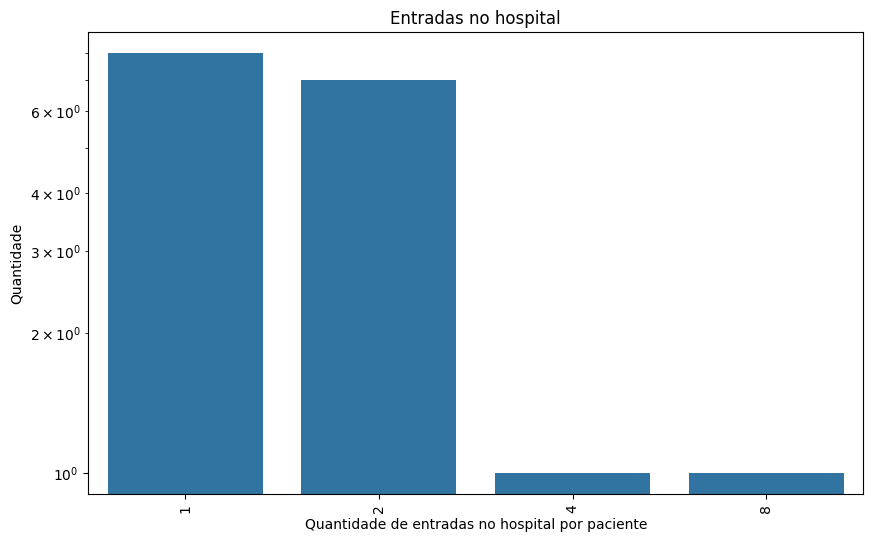

In [35]:
plt.figure(figsize=(10,6))
sns.barplot(x =entradas['entrada'],y=entradas['count'])
plt.yscale('log')
plt.xlabel('Quantidade de entradas no hospital por paciente')
plt.ylabel('Quantidade')
plt.title('Entradas no hospital')
plt.xticks(rotation=90)
plt.show()

In [36]:
bins = np.arange(0,250,10)
labels = np.array([f"{x}-{x+10}" for x in bins])


In [37]:
entradas["groups"] = labels[np.digitize(entradas["entrada"],bins)]
entradas = entradas.groupby("groups").sum().reset_index()


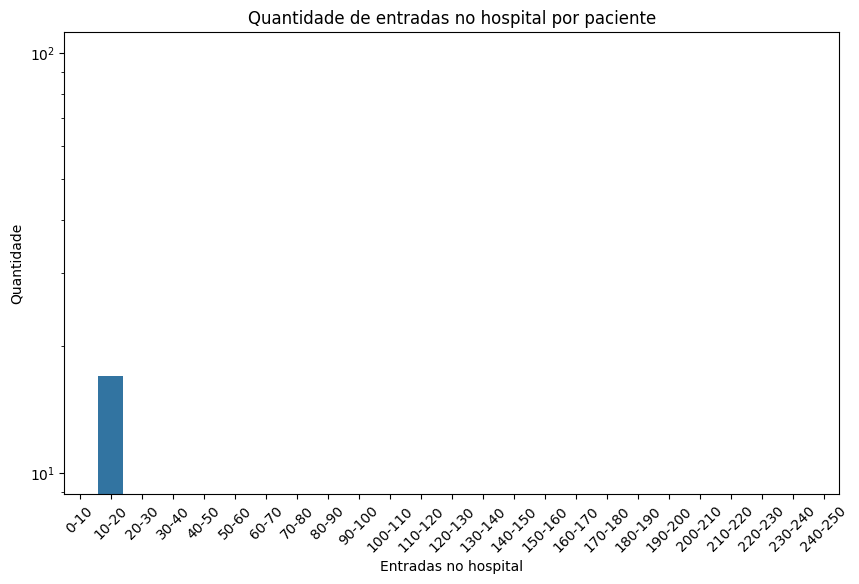

In [38]:
# Plotar os dados binarizados
plt.figure(figsize=(10, 6))
sns.barplot(x=entradas["groups"], y=entradas["count"],order=labels)
plt.yscale('log')
plt.xlabel('Entradas no hospital')
plt.ylabel('Quantidade')
plt.title('Quantidade de entradas no hospital por paciente')
plt.xticks(rotation=45)
plt.show()

### Exames

#### Seleção dos exames

In [39]:
def aggregate_events(df):
    itemid_map = {
        'Albumine': [52022, 53138, 50862, 53085],
        'Lactate': [50813, 52442, 53154],
        'Bicarbonate': [50813, 52442, 53154],
        'Chloride': [50902, 52535],
        'Hemoglobin': [50811, 51222, 51640],
        'Sodium': [50983, 52623],
        'Glucose': [50809, 50931, 52569],
        'Troponin': [51002, 51003, 52642],
        'Platelets': [51240,51704,52159],
        'INR': [51237, 51675],
        'Creatinine': [50813, 52442, 53154],
        'Bun': [51842,52647,51006],
        'Bilirubin': [50885, 53089],
        'AST': [50878, 53088],
        'ALT': [50861, 53084],
        'C_reactive': [50889],
        'ESR': [51288],
        'Bands': [51144],
        'WBC': [51301,53134,51300],
        'Oxygen_saturation': [50817],
        'Temperature': [223762],
        'Systolic_pressure': [227242, 227243],
        'Respiratory_rate': [220210],
        'Heart_rate': [220045]
    }
    
    for key, itemids in itemid_map.items():
        new_col = df['itemid'].isin(itemids) * df["value"]
        new_col[new_col == ""] = np.NaN
        new_col[new_col == "___"] = np.NaN
        df[key] = new_col
    return df


In [40]:
df_exams = pd.concat([df_selected_chartvents,df_selected_labevents],ignore_index=True)


In [41]:
df_exams

,subject_id,hadm_id,charttime,itemid,value
0,10005817,20626031.0,2132-12-16 00:00:00,220210,19
1,10005817,20626031.0,2132-12-16 00:00:00,223762,37
2,10005817,20626031.0,2132-12-16 00:00:00,220045,80
3,10005817,20626031.0,2132-12-16 01:00:00,220045,82
4,10005817,20626031.0,2132-12-16 01:00:00,223762,37
...,...,...,...,...,...
56247,10007818,22987108.0,2146-06-23 03:59:00,50825,35.9
56248,10007818,22987108.0,2146-06-23 03:59:00,50817,76
56249,10029291,22205327.0,2123-02-23 04:59:00,50813,1.2
56250,10021487,28998349.0,2116-12-07 18:59:00,50809,137


In [42]:
df_exams = pd.merge(df_exams,df_diagnostics_sepsis,on = ['subject_id', 'hadm_id'],how = 'inner')

In [43]:
df_exams = pd.merge(df_exams,df_admissions[['subject_id', 'hadm_id','admittime']],how = 'inner',on=['subject_id', 'hadm_id'])

#### Calculo do offset dos exames

In [44]:
# Convertendo colunas para datetime
df_exams['charttime'] = pd.to_datetime(df_exams['charttime'])
df_exams['admittime'] = pd.to_datetime(df_exams['admittime'])
# Calculando os offsets
df_exams['offsettime'] = df_exams['charttime'] - df_exams['admittime']

In [45]:
df_exams

,subject_id,hadm_id,charttime,itemid,value,sepsis,admittime,offsettime
0,10002428,28662225.0,2156-04-24 00:00:00,220045,86,True,2156-04-12 14:16:00,11 days 09:44:00
1,10002428,28662225.0,2156-04-24 00:00:00,220210,18,True,2156-04-12 14:16:00,11 days 09:44:00
2,10002428,28662225.0,2156-04-24 01:00:00,220210,21,True,2156-04-12 14:16:00,11 days 10:44:00
3,10002428,28662225.0,2156-04-24 01:00:00,220045,89,True,2156-04-12 14:16:00,11 days 10:44:00
4,10002428,28662225.0,2156-04-24 02:00:00,220045,83,True,2156-04-12 14:16:00,11 days 11:44:00
...,...,...,...,...,...,...,...,...
31083,10007818,22987108.0,2146-06-23 03:59:00,50825,35.9,True,2146-06-10 16:37:00,12 days 11:22:00
31084,10007818,22987108.0,2146-06-23 03:59:00,50817,76,True,2146-06-10 16:37:00,12 days 11:22:00
31085,10007818,22987108.0,2146-06-23 03:59:00,50817,76,True,2146-06-10 16:37:00,12 days 11:22:00
31086,10007818,22987108.0,2146-06-23 03:59:00,50817,76,True,2146-06-10 16:37:00,12 days 11:22:00


In [46]:
df_exams = aggregate_events(df_exams)
df_exams.drop(['itemid','value'],axis = 1,inplace = True)

In [47]:
df_exams

,subject_id,hadm_id,charttime,sepsis,admittime,offsettime,Albumine,Lactate,Bicarbonate,Chloride,...,ALT,C_reactive,ESR,Bands,WBC,Oxygen_saturation,Temperature,Systolic_pressure,Respiratory_rate,Heart_rate
0,10002428,28662225.0,2156-04-24 00:00:00,True,2156-04-12 14:16:00,11 days 09:44:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86
1,10002428,28662225.0,2156-04-24 00:00:00,True,2156-04-12 14:16:00,11 days 09:44:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN
2,10002428,28662225.0,2156-04-24 01:00:00,True,2156-04-12 14:16:00,11 days 10:44:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,NaN
3,10002428,28662225.0,2156-04-24 01:00:00,True,2156-04-12 14:16:00,11 days 10:44:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89
4,10002428,28662225.0,2156-04-24 02:00:00,True,2156-04-12 14:16:00,11 days 11:44:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31083,10007818,22987108.0,2146-06-23 03:59:00,True,2146-06-10 16:37:00,12 days 11:22:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31084,10007818,22987108.0,2146-06-23 03:59:00,True,2146-06-10 16:37:00,12 days 11:22:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,76,NaN,NaN,NaN,NaN
31085,10007818,22987108.0,2146-06-23 03:59:00,True,2146-06-10 16:37:00,12 days 11:22:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,76,NaN,NaN,NaN,NaN
31086,10007818,22987108.0,2146-06-23 03:59:00,True,2146-06-10 16:37:00,12 days 11:22:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,76,NaN,NaN,NaN,NaN


In [48]:
df_exams['days'] = (df_exams['offsettime'].dt.total_seconds()//(60*60*24)).values.astype(int)
df_exams['hours'] = (df_exams['offsettime'].dt.total_seconds()//(60*60)).values.astype(int)

#### Visualização

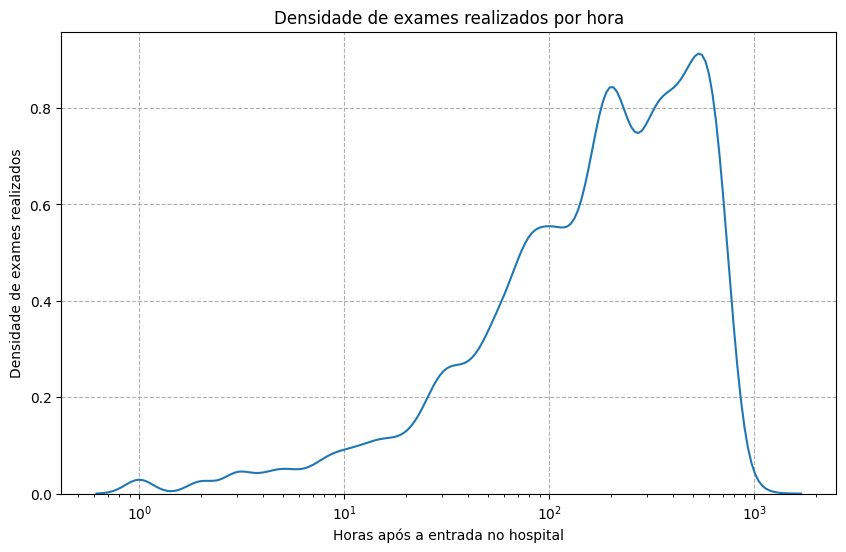

In [49]:
# Criar o gráfico de linhas
plt.figure(figsize=(10,6))
sns.kdeplot(df_exams[df_exams['hours']>0]['hours'], log_scale=True)
plt.xlabel('Horas após a entrada no hospital')
plt.ylabel('Densidade de exames realizados')
plt.title('Densidade de exames realizados por hora')
plt.grid(True, which="major", ls="--")
plt.show()


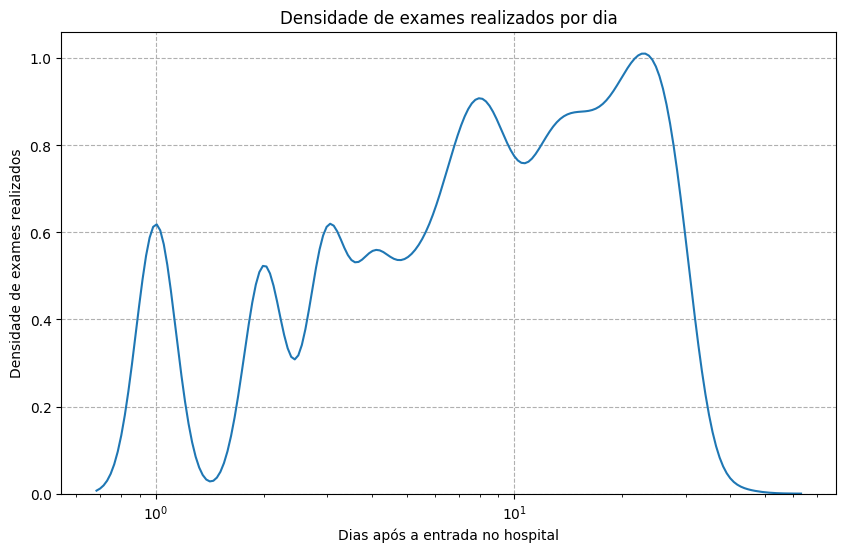

In [50]:
# Criar o gráfico de linhas
plt.figure(figsize=(10,6))
sns.kdeplot(df_exams[df_exams['days']>0]['days'], log_scale=True)
plt.xlabel('Dias após a entrada no hospital')
plt.ylabel('Densidade de exames realizados')
plt.title('Densidade de exames realizados por dia')
plt.grid(True, which="major", ls="--")
plt.show()


/tmp/ipykernel_248103/787877528.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


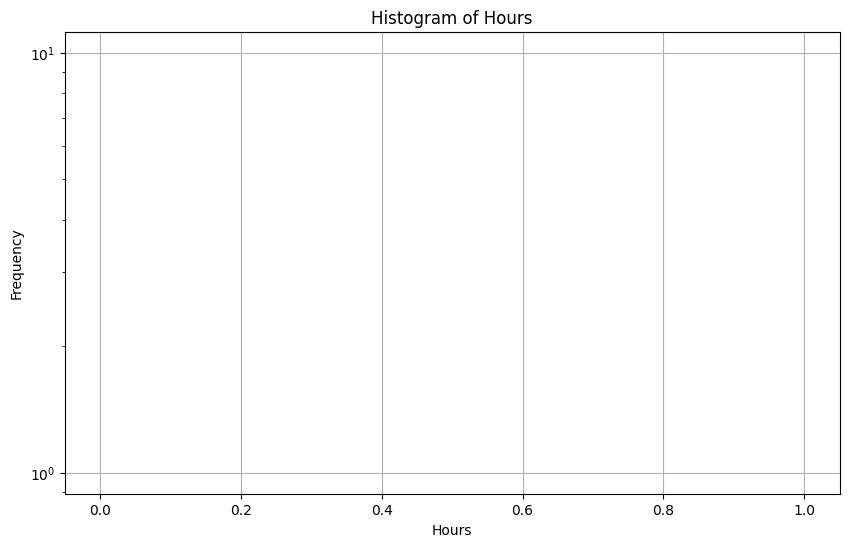

In [80]:
def generate_analysis(column):
    exam = df_exams[['hours',column]]
    exam = exam.dropna()
    plt.figure(figsize=(10, 6))
    plt.hist(exam['hours'], bins=10, edgecolor='black')
    plt.yscale('log')
    plt.title('Histogram of Hours')
    plt.xlabel('Hours')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
exams = ['Albumine', 'Lactate', 'Bicarbonate', 'Chloride',
       'Hemoglobin', 'Sodium', 'Glucose', 'Troponin', 'Platelets', 'INR',
       'Creatinine', 'Bun', 'Bilirubin', 'AST', 'ALT', 'C_reactive', 'ESR',
       'Bands', 'WBC', 'Oxygen_saturation', 'Temperature', 'Systolic_pressure',
       'Respiratory_rate', 'Heart_rate']
for column in exams:
    generate_analysis(column)

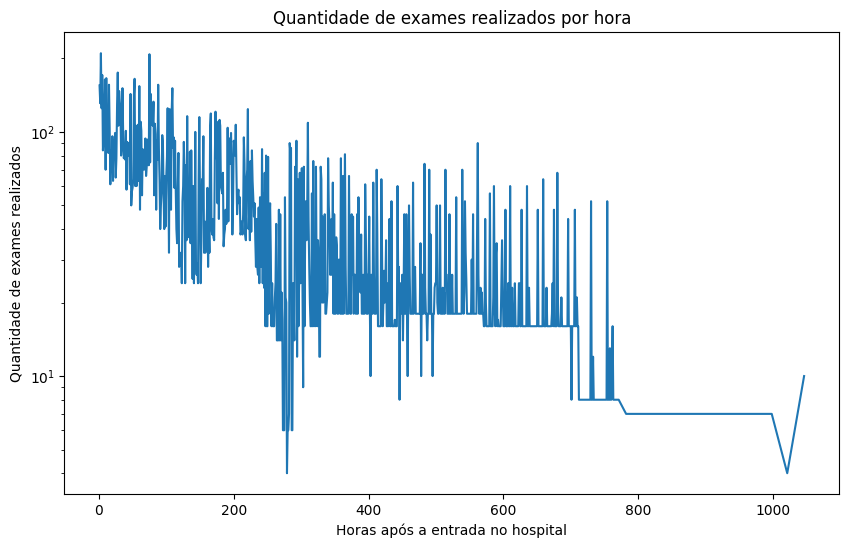

In [51]:
hourly_counts = df_exams[df_exams['hours']>0]['hours'].value_counts().sort_index()

# Criar o gráfico de linhas com o eixo y em escala logarítmica
plt.figure(figsize=(10, 6))
plt.plot(hourly_counts.index, hourly_counts.values)
plt.yscale('log')
plt.xlabel('Horas após a entrada no hospital')
plt.ylabel('Quantidade de exames realizados')
plt.title('Quantidade de exames realizados por hora')
plt.show()

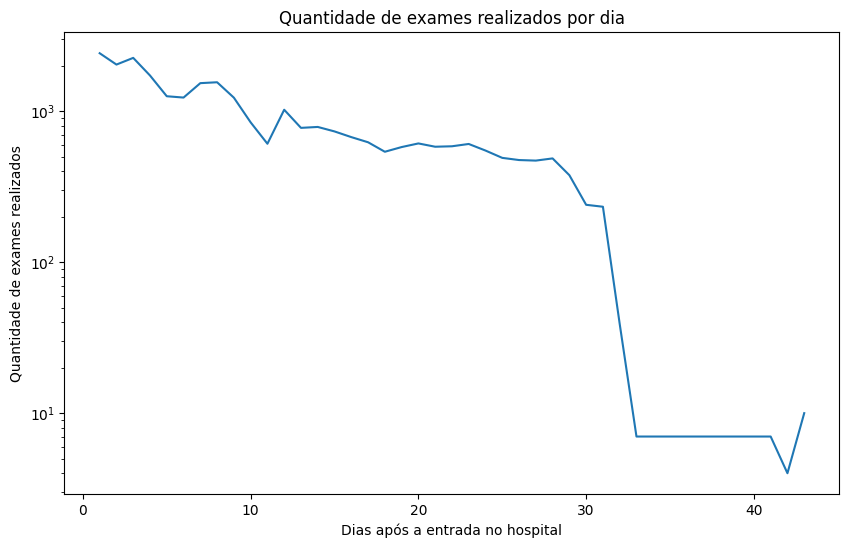

In [52]:
days_counts = df_exams[df_exams['days']>0]['days'].value_counts().sort_index()

# Criar o gráfico de linhas com o eixo y em escala logarítmica
plt.figure(figsize=(10, 6))
plt.plot(days_counts.index, days_counts.values)
plt.yscale('log')
plt.xlabel('Dias após a entrada no hospital')
plt.ylabel('Quantidade de exames realizados')
plt.title('Quantidade de exames realizados por dia')
plt.show()

In [53]:
df_diagnostics_sepsis

,subject_id,hadm_id,sepsis
12,10009049,22995465,True
348,10007928,20338077,True
454,10020786,23488445,True
463,10020786,23488445,True
557,10007818,22987108,True
568,10007818,22987108,True
626,10004235,24181354,True
771,10018081,21027282,True
1016,10020944,29974575,True
1172,10037861,24540843,True


In [54]:
df_admissions = pd.merge(df_admissions[['subject_id','hadm_id']],df_diagnostics_sepsis,how='inner',on = ['subject_id','hadm_id'])
df_admissions

,subject_id,hadm_id,sepsis
0,10004235,24181354,True
1,10020740,23831430,True
2,10020786,23488445,True
3,10020786,23488445,True
4,10020786,23488445,True
5,10020786,23488445,True
6,10003400,23559586,True
7,10003400,23559586,True
8,10003400,23559586,True
9,10003400,23559586,True


#### Cálculo dos nulos


In [55]:
def stats(delta):
    df_exams_filtrado = df_exams[df_exams['admittime']!= 'NaT']
    df_stats = df_exams_filtrado[(df_exams_filtrado['hours']>0) & (df_exams_filtrado['hours']<=delta)]
    pacientes_que_fizeram_exame = df_stats.groupby(['subject_id','hadm_id']).apply(lambda x: x.notna().any(),include_groups=False)
    qtd_pacientes_que_fizeram_exame = pacientes_que_fizeram_exame.sum()

    total_patients = len(df_admissions[['subject_id','hadm_id']])
    df_stats = pd.DataFrame((total_patients-qtd_pacientes_que_fizeram_exame)/total_patients).reset_index()
    df_stats.columns = ["exams","porcentagem_de_nulos"]
    return df_stats["exams"],df_stats["porcentagem_de_nulos"]

In [56]:
def tratamento(df):
    df.loc[:,df.columns!="exams"] *= 100
    df.loc[:,df.columns!="exams"] = df.loc[:,df.columns!="exams"].round(2)
    df.loc[:,df.columns!="exams"] = df.loc[:,df.columns!="exams"].astype(str) + '%'
    return df


In [57]:
colunas,null_stats = stats(24)
df_stats = pd.DataFrame(colunas)
df_stats["porcentagem_de_nulos_24h"] = null_stats
_,null_stats = stats(48) 
df_stats["porcentagem_de_nulos_48h"] = null_stats
_,null_stats = stats(72)
df_stats["porcentagem_de_nulos_72h"] = null_stats
df_stats = tratamento(df_stats)
df_stats

/tmp/ipykernel_248103/2011754202.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['57.41%' '57.41%' '57.41%' '57.41%' '85.19%' '70.37%' '70.37%' '57.41%'
 '57.41%' '62.96%' '96.3%' '100.0%' '100.0%' '62.96%' '70.37%' '57.41%'
 '74.07%' '74.07%' '74.07%' '100.0%' '98.15%' '90.74%' '57.41%' '96.3%'
 '98.15%' '98.15%' '66.67%' '66.67%' '57.41%' '57.41%']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:,df.columns!="exams"] = df.loc[:,df.columns!="exams"].astype(str) + '%'
/tmp/ipykernel_248103/2011754202.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['55.56%' '55.56%' '55.56%' '55.56%' '79.63%' '66.67%' '66.67%' '55.56%'
 '55.56%' '59.26%' '94.44%' '100.0%' '100.0%' '59.26%' '66.67%' '55.56%'
 '70.37%' '72.22%' '72.22%' '100.0%' '98.15%' '88.89%' '55.56%' '96.3%'
 '98.15%' '98.15%' '66.

,exams,porcentagem_de_nulos_24h,porcentagem_de_nulos_48h,porcentagem_de_nulos_72h
0,charttime,57.41%,55.56%,55.56%
1,sepsis,57.41%,55.56%,55.56%
2,admittime,57.41%,55.56%,55.56%
3,offsettime,57.41%,55.56%,55.56%
4,Albumine,85.19%,79.63%,70.37%
5,Lactate,70.37%,66.67%,66.67%
6,Bicarbonate,70.37%,66.67%,66.67%
7,Chloride,57.41%,55.56%,55.56%
8,Hemoglobin,57.41%,55.56%,55.56%
9,Sodium,62.96%,59.26%,59.26%
